# Demonstrate how to use ERA5 fields for two MCS cases over Hong Kong

* Cases: 20/4/2019, 25/8/2019
* I've copied data from 2 days before to 2 days after
* I've kept everything within 10deg of HK (approx 1100 km)
* Data available:
  * Surface (sfc, 2D): CAPE, TCWV
  * Model levels (ml, 3D): u, v, z (geopot), lnsp (log of sea-level pressure), q (specific humidity)
* You will need both metpy and xgcm installed to run full notebook. See below for how to do this

Below, there are some examples to get you started. First, you can see where the data is located and how to load using xarray. Then, there are some basic plots of 2D fields, and 3D fields at given model levels. There is also some code you can adapt for plotting transects (over model levels)

After that, there is some code to calculate pressure as a 3D field and to do interpolation of other 3D fields onto given pressure levels. Again, there is some code for plotting transects (over pressure levels).

Feel free to adapt this code as you see fit. It is written as direct statements into the notebook - I would recommend using some functions for the key parts that you find useful, e.g. plotting transects etc.


In [1]:
from pathlib import Path

# These are all available as standard in Python 3 + Jaspy kernel.
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# All files are under here in format based on year/month/day/*.nc
# Note all times are in UTC.
basepath = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/regional_ERA5_data/HongKong')

In [3]:
# Use 2019/4/20 06:00Z as start time.
t = pd.Timestamp(2019, 4, 20, 6, 0)

In [4]:
# Utility functions to generate a path from a time and a variable name.
def era5_sfc_path(t, var):
    filename = f'ecmwf-era5_oper_an_sfc_{t.year}{t.month:02d}{t.day:02d}{t.hour:02d}00.hong_kong.{var}.nc'
    return basepath / f'{t.year}/{t.month:02d}/{t.day:02d}' / filename

def era5_ml_path(t, var):
    filename = f'ecmwf-era5_oper_an_ml_{t.year}{t.month:02d}{t.day:02d}{t.hour:02d}00.hong_kong.{var}.nc'
    return basepath / f'{t.year}/{t.month:02d}/{t.day:02d}' / filename

In [5]:
cape_path = era5_sfc_path(t, 'cape')
tcwv_path = era5_sfc_path(t, 'tcwv')
cape_path

PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/regional_ERA5_data/HongKong/2019/04/20/ecmwf-era5_oper_an_sfc_201904200600.hong_kong.cape.nc')

In [6]:
# Load two surface (2D) fields, CAPE and TCWV
cape = xr.open_dataarray(cape_path)
tcwv = xr.open_dataarray(tcwv_path)

In [7]:
# Have a look at cape (xarray.DataArray)
# Note it has a time coord that we are not interested in here.
cape

<xarray.DataArray 'cape' (time: 1, latitude: 80, longitude: 80)>
array([[[6.533203e-01, 2.441406e-04, ..., 2.441406e-04, 2.441406e-04],
        [6.533203e-01, 2.441406e-04, ..., 2.441406e-04, 2.441406e-04],
        ...,
        [1.411263e+03, 1.361707e+03, ..., 3.884192e+02, 1.007913e+02],
        [1.296659e+03, 1.257743e+03, ..., 4.083909e+02, 4.829575e+02]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 104.2 104.5 104.8 105.0 ... 123.5 123.8 124.0
  * latitude   (latitude) float32 32.25 32.0 31.75 31.5 ... 13.0 12.75 12.5
  * time       (time) datetime64[ns] 2019-04-20T06:00:00
Attributes:
    units:      J kg**-1
    long_name:  Convective available potential energy

In [8]:
tcwv

<xarray.DataArray 'tcwv' (time: 1, latitude: 80, longitude: 80)>
array([[[18.88433 , 20.342724, ..., 15.73609 , 14.934986],
        [21.153942, 23.417933, ..., 16.723707, 15.839458],
        ...,
        [53.197014, 53.16555 , ..., 41.214146, 44.809566],
        [52.21389 , 52.157707, ..., 38.905212, 45.332027]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 104.2 104.5 104.8 105.0 ... 123.5 123.8 124.0
  * latitude   (latitude) float32 32.25 32.0 31.75 31.5 ... 13.0 12.75 12.5
  * time       (time) datetime64[ns] 2019-04-20T06:00:00
Attributes:
    units:          kg m**-2
    long_name:      Total column water vapour
    standard_name:  lwe_thickness_of_atmosphere_mass_content_of_water_vapor

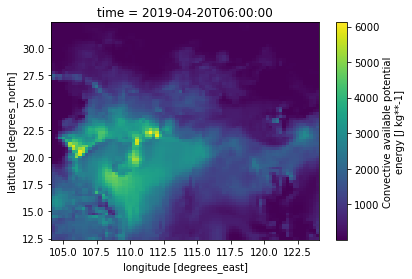

In [9]:
# Quick plot to check it looks sensible (you can pick out coastlines by eye)
cape.plot()

In [10]:
# Define a map projection for a nicer plot, roughly centred on Hong Kong
map_proj = ccrs.LambertConformal(central_longitude=112, central_latitude=20)

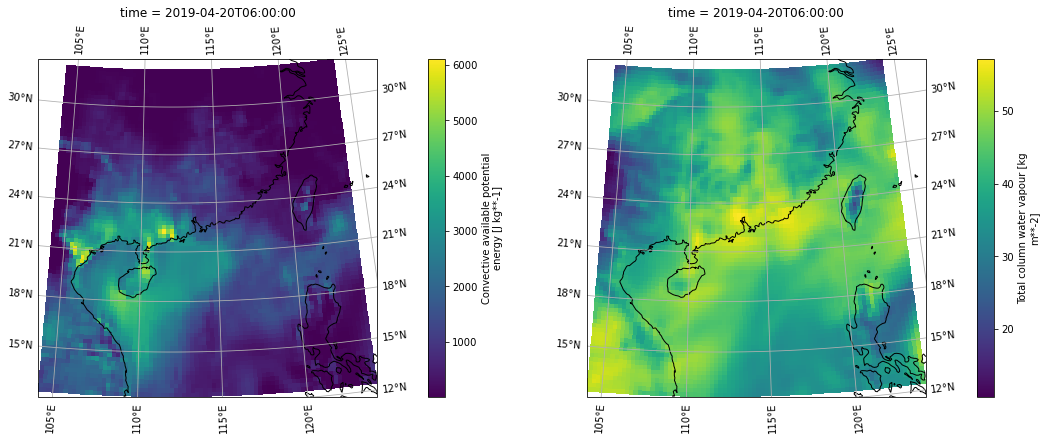

In [11]:
# Quick plot of CAPE and TCWV. Note, the data is on a lat/lon grid, so use PlateCarree transform.
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection=map_proj), layout='constrained')
fig.set_size_inches((15, 6))
cape.plot(ax=ax1, transform=ccrs.PlateCarree())
tcwv.plot(ax=ax2, transform=ccrs.PlateCarree())
for ax in (ax1, ax2):
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

In [12]:
# Load specific humidity (3D field)
# It is defined on ERA5 model levels. Level 137 is the surface.
q_path = era5_ml_path(t, 'q')

q = xr.open_dataarray(q_path)
q

<xarray.DataArray 'q' (time: 1, level: 137, latitude: 80, longitude: 80)>
[876800 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 104.2 104.5 104.8 105.0 ... 123.5 123.8 124.0
  * latitude   (latitude) float32 32.25 32.0 31.75 31.5 ... 13.0 12.75 12.5
  * level      (level) int32 1 2 3 4 5 6 7 8 ... 130 131 132 133 134 135 136 137
  * time       (time) datetime64[ns] 2019-04-20T06:00:00
Attributes:
    units:          kg kg**-1
    long_name:      Specific humidity
    standard_name:  specific_humidity

In [13]:
# Define lat/lon of transect we want to use.
transect_lat = xr.DataArray(np.linspace(15, 24, 100), dims='transect')
transect_lon = xr.DataArray(np.linspace(115, 112, 100), dims='transect')

In [14]:
# Interp q to transect. This creates a new variable with a 'transect' dimension/coord.
q_transect = q.interp(latitude=transect_lat, longitude=transect_lon)

In [15]:
q_transect

<xarray.DataArray 'q' (time: 1, level: 137, transect: 100)>
array([[[1.32527202e-06, 1.32527202e-06, 1.32527202e-06, ...,
         1.32527202e-06, 1.32527202e-06, 1.32527202e-06],
        [2.03587115e-06, 2.03587115e-06, 2.03587115e-06, ...,
         2.03587115e-06, 2.03587115e-06, 2.03587115e-06],
        [2.74647027e-06, 2.74647027e-06, 2.74647027e-06, ...,
         2.74647027e-06, 2.74647027e-06, 2.74647027e-06],
        ...,
        [1.82522312e-02, 1.82545346e-02, 1.82359363e-02, ...,
         1.78294261e-02, 1.76344055e-02, 1.73990857e-02],
        [1.83656290e-02, 1.83651073e-02, 1.83438093e-02, ...,
         1.79275337e-02, 1.77357564e-02, 1.75032411e-02],
        [1.86233483e-02, 1.86183697e-02, 1.85928339e-02, ...,
         1.81583845e-02, 1.79728902e-02, 1.77460313e-02]]])
Coordinates:
  * level      (level) int32 1 2 3 4 5 6 7 8 ... 130 131 132 133 134 135 136 137
  * time       (time) datetime64[ns] 2019-04-20T06:00:00
    latitude   (transect) float64 15.0 15.09 15.18 15.27 ... 23.82 23.91 24.0
    longitude  (transect) float64 115.0 115.0 114.9 114.9 ... 112.1 112.0 112.0
Dimensions without coordinates: transect
Attributes:
    units:          kg kg**-1
    long_name:      Specific humidity
    standard_name:  specific_humidity

(137.0, 0.0)

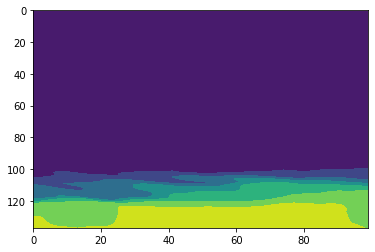

In [16]:
# Plot q along transect. This is in model levels.
plt.contourf(q_transect.transect.values, q_transect.level.values, q_transect.values[0]) # [0] gets rid of time dim.
plt.ylim((137, 0))

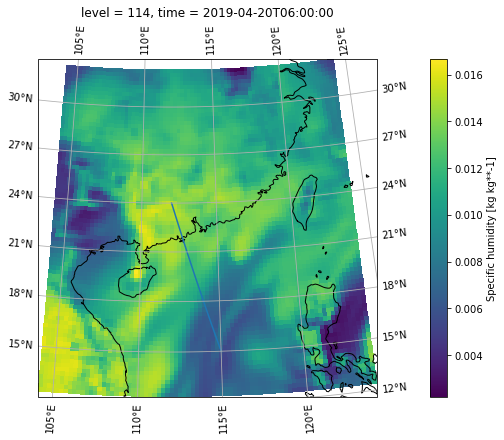

In [17]:
# Plot q at level 114 (approx 850 hPa: https://confluence.ecmwf.int/display/UDOC/L137+model+level+definitions)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=map_proj), layout='constrained')
fig.set_size_inches((8, 6))
q.isel(time=0).sel(level=114).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
# Also show transect as line
ax.plot(transect_lon, transect_lat, transform=ccrs.PlateCarree())

(137.0, 0.0)

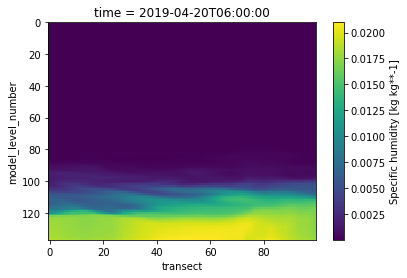

In [18]:
q_transect.plot()
plt.ylim((137, 0))

## Below here, you will need metpy installed!

One way of doing this is to
* Click the blue plus near top left of pane (may need to expand sidebar)
* Go to Console -> Python 3 + Jaspy
* Run "pip install --user metpy xgcm"
* Restart your kernel

In [19]:
from era5_calc import ERA5Calc

In [20]:
model_levels = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/') / 'ERA5/ERA5_L137_model_levels_table.csv'
e5calc = ERA5Calc(model_levels)

In [21]:
lnsp_path = era5_ml_path(t, 'lnsp')  # log surface pressure. Can be used to calc pressure on all model levels.
lnsp = xr.open_dataarray(lnsp_path)
lnsp

<xarray.DataArray 'lnsp' (time: 1, latitude: 80, longitude: 80)>
array([[[11.296332, 11.341659, ..., 11.526106, 11.526106],
        [11.318521, 11.366843, ..., 11.526061, 11.526039],
        ...,
        [11.516455, 11.517685, ..., 11.517439, 11.510303],
        [11.512574, 11.517181, ..., 11.517472, 11.515795]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 104.2 104.5 104.8 105.0 ... 123.5 123.8 124.0
  * latitude   (latitude) float32 32.25 32.0 31.75 31.5 ... 13.0 12.75 12.5
  * time       (time) datetime64[ns] 2019-04-20T06:00:00
Attributes:
    units:      ~
    long_name:  Logarithm of surface pressure

In [22]:
# Do pressure calc. Note, p in Pa (not hPa)
# As per: https://confluence.ecmwf.int/display/CKB/ERA5:%20compute%20pressure%20and%20geopotential%20on%20model%20levels,%20geopotential%20height%20and%20geometric%20height
p = e5calc.calc_pressure(lnsp.isel(time=0).values)

In [23]:
p.shape  # defined on all model levels

(137, 80, 80)

In [24]:
p[114].mean()  # (approx 850 hPa)

83687.98550918896

## Below here, you will need xgcm installed!

Interpolate q, u, v onto pressure levels.

In [25]:
from xgcm import Grid

In [26]:
# Create a pressure xarray.DataArray
da_p = xr.DataArray(
    p / 100, # convert from Pa to hPa
    dims=['level', 'latitude', 'longitude'],
    coords=dict(
        level=q.level,
        latitude=q.latitude,
        longitude=q.longitude,
    ),
    attrs=dict(
        units='hPa',
        standard='air_pressure',
    )
)

In [27]:
# This is amazingly easy AND amazingly powerful.
# Interpolate u onto 19x pressure levels.
ds_p = da_p.to_dataset(name='pressure')
grid = Grid(ds_p, coords=dict(pressure={'center': 'level'}), periodic=False)
q_plev = grid.transform(
    q,
    'pressure',
    np.linspace(1000, 100, 19),
    target_data=ds_p.pressure,
    method='linear'
)
# Set to natural coord order.
q_plev = q_plev.transpose('time', 'pressure', 'latitude', 'longitude')

# Have a look at DataArray. Note, nans represent intersection of pressure level with orography.
q_plev

/opt/jaspy/lib/python3.10/site-packages/xgcm/grid.py:987: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


<xarray.DataArray 'q' (time: 1, pressure: 19, latitude: 80, longitude: 80)>
array([[[[           nan,            nan,            nan, ...,
          8.78130663e-03, 8.82104319e-03, 8.89512488e-03],
         [           nan,            nan,            nan, ...,
          8.91055045e-03, 8.82319837e-03, 8.88328791e-03],
         [           nan,            nan,            nan, ...,
          9.13490824e-03, 9.02324777e-03, 8.90812004e-03],
         ...,
         [1.67166398e-02, 1.71256201e-02, 1.71673552e-02, ...,
                     nan,            nan,            nan],
         [1.68420714e-02, 1.65292401e-02, 1.62895870e-02, ...,
          1.80627950e-02, 1.75219870e-02,            nan],
         [           nan, 1.62383399e-02, 1.59943458e-02, ...,
          1.77735749e-02, 1.77174319e-02, 1.80183378e-02]],

        [[           nan,            nan,            nan, ...,
          5.49522505e-03, 4.71595474e-03, 4.08492989e-03],
         [           nan,            nan,            nan, ...,
          7.05277978e-03, 6.24190170e-03, 5.56165033e-03],
         [           nan,            nan,            nan, ...,
          8.78202609e-03, 8.17019344e-03, 7.80394096e-03],
...
         [1.79392150e-05, 1.74824290e-05, 1.70259138e-05, ...,
          7.17758006e-06, 7.53682157e-06, 7.89470952e-06],
         [1.74822819e-05, 1.69186467e-05, 1.64617889e-05, ...,
          8.02946672e-06, 8.64007085e-06, 9.35600247e-06],
         [1.69236702e-05, 1.64612169e-05, 1.61053273e-05, ...,
          9.24857631e-06, 9.95918266e-06, 1.09225512e-05]],

        [[2.03587115e-06, 2.03587115e-06, 2.03587115e-06, ...,
          2.39163637e-06, 2.39163637e-06, 2.39163637e-06],
         [2.03587115e-06, 2.03587115e-06, 2.03587115e-06, ...,
          2.39163637e-06, 2.39163637e-06, 2.39163637e-06],
         [2.03587115e-06, 2.03587115e-06, 2.03587115e-06, ...,
          2.39163637e-06, 2.39163637e-06, 2.39163637e-06],
         ...,
         [2.85308976e-06, 2.85311274e-06, 2.85315619e-06, ...,
          2.60475474e-06, 2.60484717e-06, 2.60492096e-06],
         [2.85311078e-06, 2.85308388e-06, 2.85311396e-06, ...,
          2.60447341e-06, 2.60459524e-06, 2.49813140e-06],
         [3.10223550e-06, 3.10223550e-06, 3.10223550e-06, ...,
          2.49797504e-06, 2.49797552e-06, 2.49801209e-06]]]])
Coordinates:
  * longitude  (longitude) float32 104.2 104.5 104.8 105.0 ... 123.5 123.8 124.0
  * latitude   (latitude) float32 32.25 32.0 31.75 31.5 ... 13.0 12.75 12.5
  * time       (time) datetime64[ns] 2019-04-20T06:00:00
  * pressure   (pressure) float64 1e+03 950.0 900.0 850.0 ... 200.0 150.0 100.0

In [28]:
# As before, calc transect. This time in pressure coords!
q_plev_transect = q_plev.interp(latitude=transect_lat, longitude=transect_lon)

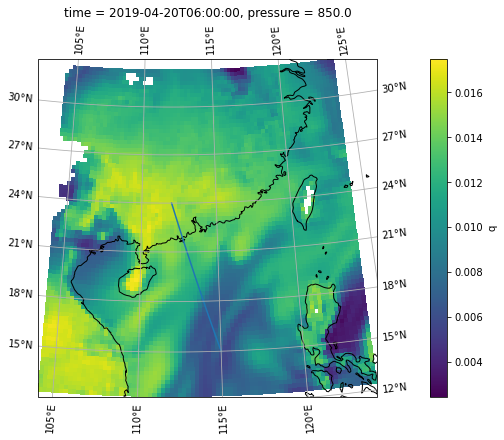

In [29]:
# Plot actual 850 hPa q + transect line
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=map_proj), layout='constrained')
fig.set_size_inches((8, 6))
q_plev.isel(time=0).sel(pressure=850).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.plot(transect_lon, transect_lat, transform=ccrs.PlateCarree())

(1000.0, 100.0)

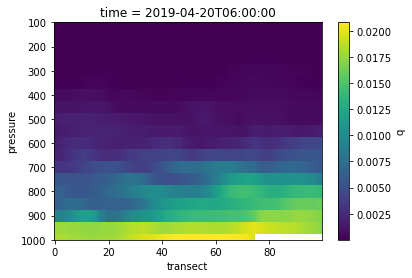

In [30]:
# Plot 2D cross section along transect
q_plev_transect.plot()
plt.ylim((1000, 100))

In [31]:
# Load u, v (3D fields)
u_path = era5_ml_path(t, 'u')
v_path = era5_ml_path(t, 'v')
uv = xr.open_mfdataset([u_path, v_path]).load()

In [32]:
# Get at 850 hPa
u850 = grid.transform(
    uv.u,
    'pressure',
    np.array([850]),
    target_data=ds_p.pressure,
    method='linear'
).isel(pressure=0)
v850 = grid.transform(
    uv.v,
    'pressure',
    np.array([850]),
    target_data=ds_p.pressure,
    method='linear'
).isel(pressure=0)

/opt/jaspy/lib/python3.10/site-packages/xgcm/grid.py:987: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


In [33]:
p

array([[[1.00018250e+00, 1.00018250e+00, 1.00018250e+00, ...,
         1.00018250e+00, 1.00018250e+00, 1.00018250e+00],
        [1.00018250e+00, 1.00018250e+00, 1.00018250e+00, ...,
         1.00018250e+00, 1.00018250e+00, 1.00018250e+00],
        [1.00018250e+00, 1.00018250e+00, 1.00018250e+00, ...,
         1.00018250e+00, 1.00018250e+00, 1.00018250e+00],
        ...,
        [1.00018250e+00, 1.00018250e+00, 1.00018250e+00, ...,
         1.00018250e+00, 1.00018250e+00, 1.00018250e+00],
        [1.00018250e+00, 1.00018250e+00, 1.00018250e+00, ...,
         1.00018250e+00, 1.00018250e+00, 1.00018250e+00],
        [1.00018250e+00, 1.00018250e+00, 1.00018250e+00, ...,
         1.00018250e+00, 1.00018250e+00, 1.00018250e+00]],

       [[2.55130300e+00, 2.55130300e+00, 2.55130300e+00, ...,
         2.55130300e+00, 2.55130300e+00, 2.55130300e+00],
        [2.55130300e+00, 2.55130300e+00, 2.55130300e+00, ...,
         2.55130300e+00, 2.55130300e+00, 2.55130300e+00],
        [2.55130300e+00, 